# Import Lib

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow import keras
import plotly.graph_objects as go

from google.colab import drive
import os
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# PATH

In [ ]:
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/')

project_path = "Report_DBA/"
source_path = project_path + "source/"
data_path = project_path + "data/BTC-USD.csv"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv(data_path)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1822,04/22/2023,27265.89453,27872.14258,27169.57031,27817.50000,27817.50000,1.312573e+10
1823,04/23/2023,27816.14453,27820.24414,27400.31445,27591.38477,27591.38477,1.278545e+10
1824,04/24/2023,27591.73047,27979.98242,27070.84961,27525.33984,27525.33984,1.770329e+10
1825,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1826,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   Open       1825 non-null   float64
 2   High       1825 non-null   float64
 3   Low        1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Adj Close  1825 non-null   float64
 6   Volume     1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 100.0+ KB


Nhận thấy dữ liệu có 1827 dòng nhưng có 2 dòng bị thiếu ==> Vậy nên cần xử lý các dòng đó

In [ ]:
# do 2 dòng này nằm cuối dữ liệu nên không cần tìm giá trị thay thế mà trực tiếp loại bỏ
df.dropna(inplace=True)

# Plot

In [ ]:
fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'], high=df['High'],
                low=df['Low'], close=df['Close'])
                     ])

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

# Train Test vs Validation Split

In [ ]:
n_observations = df.shape[0]

# Sử dụng giá đóng cửa của 3 ngày trước đó để dự đoán gia đóng cửa hiện tại
df["Close-1"] = df["Adj Close"].shift(1)
df["Close-2"] = df["Adj Close"].shift(2)
df["Close-3"] = df["Adj Close"].shift(3)

df.dropna(inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close-1,Close-2,Close-3
3,04/29/2018,9346.410156,9531.490234,9193.709961,9419.080078,9419.080078,8.853000e+09,9348.480469,8987.049805,9281.509766
4,04/30/2018,9426.110352,9477.139648,9166.809570,9240.549805,9240.549805,8.673920e+09,9419.080078,9348.480469,8987.049805
5,05/01/2018,9251.469727,9255.879883,8891.049805,9119.009766,9119.009766,7.713020e+09,9240.549805,9419.080078,9348.480469
6,05/02/2018,9104.599609,9256.519531,9015.139648,9235.919922,9235.919922,7.558160e+09,9119.009766,9240.549805,9419.080078
7,05/03/2018,9233.969727,9798.330078,9188.150391,9743.860352,9743.860352,1.020730e+10,9235.919922,9119.009766,9240.549805


In [ ]:
features = ["Close-1", "Close-2", "Close-3"]
target = ["Adj Close"]

# Chọn các đặc trưng và giá đóng cửa của ngày tiếp theo làm target
X = df[features]
y = df[target]

In [ ]:
X.head()

,Close-1,Close-2,Close-3
3,9348.480469,8987.049805,9281.509766
4,9419.080078,9348.480469,8987.049805
5,9240.549805,9419.080078,9348.480469
6,9119.009766,9240.549805,9419.080078
7,9235.919922,9119.009766,9240.549805


In [ ]:
# n_observations = df.shape[0]
# # Tách dữ liệu thành tập huấn luyện và tập kiểm tra
# X_train, X_test, y_train, y_test = train_test_split(X[:int(n_observations*0.9)], y[:int(n_observations*0.9)], test_size=.2857142857142857, shuffle=False)
# X_val, y_val = X[int(n_observations*0.9): ], y[int(n_observations*0.9): ]

In [ ]:
X_train, y_train = X[:int(n_observations*0.7)], y[:int(n_observations*0.7)]
X_test, y_test = X[int(n_observations*0.7):int(n_observations*0.9)], y[int(n_observations*0.7):int(n_observations*0.9)]
X_val, y_val = X[int(n_observations*0.9): ], y[int(n_observations*0.9): ]

# XGBOOST

In [ ]:
# Xác định các tham số cho mô hình XGBoost
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.01,
    'n_estimators': 1000,
    'eval_metric' : mean_squared_error,
}

# Xây dựng mô hình XGBoost
model = XGBRegressor(**params)
model.fit(X_train, y_train, 
          eval_set=[(X_val, y_val)]
          )

[0]	validation_0-rmse:21922.60265	validation_0-mean_squared_error:480600512.00000
[1]	validation_0-rmse:21696.24635	validation_0-mean_squared_error:470727104.00000
[2]	validation_0-rmse:21466.00409	validation_0-mean_squared_error:460789312.00000
[3]	validation_0-rmse:21244.23461	validation_0-mean_squared_error:451317536.00000
[4]	validation_0-rmse:21018.55887	validation_0-mean_squared_error:441779808.00000
[5]	validation_0-rmse:20801.29264	validation_0-mean_squared_error:432693792.00000
[6]	validation_0-rmse:20581.02288	validation_0-mean_squared_error:423578464.00000
[7]	validation_0-rmse:20363.00120	validation_0-mean_squared_error:414651840.00000
[8]	validation_0-rmse:20144.58911	validation_0-mean_squared_error:405804512.00000
[9]	validation_0-rmse:19931.02293	validation_0-mean_squared_error:397245632.00000
[10]	validation_0-rmse:19725.46552	validation_0-mean_squared_error:389093952.00000
[11]	validation_0-rmse:19516.19028	validation_0-mean_squared_error:380881728.00000
[12]	validatio

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x7fa40c25d750>,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

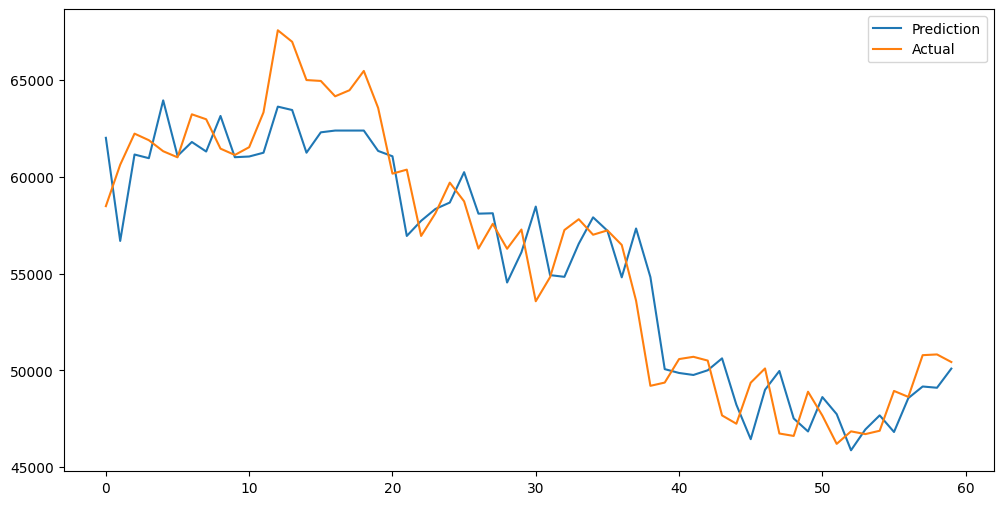

In [ ]:
# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)
plt.figure(figsize=(12, 6))

days = 60
x_axis = np.arange(0,days)
plt.plot(x_axis, y_pred[:days], label="Prediction")
plt.plot(x_axis, y_test[:days], label="Actual")
plt.legend()
plt.show()

In [ ]:
# Đánh giá hiệu suất của mô hình
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Error", mae)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Percentage Error:", mape)

Mean Absolute Error 1250.1499784041096
Root Mean Squared Error: 1658.0131345262819
Mean Absolute Percentage Error: 0.0380919575207202


In [ ]:
y_pred[0]

62011.414

In [ ]:
y_test.values[0]

array([58482.38672])

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import LSTM
# prepare sequence
length = 5
seq = array([i/float(length) for i in range(length)])
X = seq.reshape(1, length, 1)
y = seq.reshape(1, length, 1)
# define LSTM configuration
n_neurons = length
n_batch = 1
n_epoch = 1000
# create LSTM
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(length, 1), return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
# train LSTM
model.fit(X, y, epochs=n_epoch, batch_size=n_batch, verbose=2)
# evaluate
result = model.predict(X, batch_size=n_batch, verbose=0)
for value in result[0,:,0]:
	print('%.1f' % value)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 5)              140       
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 1)             6         
 tributed)                                                       
                                                                 
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
1/1 - 3s - loss: 0.2158 - 3s/epoch - 3s/step
Epoch 2/1000
1/1 - 0s - loss: 0.2131 - 14ms/epoch - 14ms/step
Epoch 3/1000
1/1 - 0s - loss: 0.2104 - 10ms/epoch - 10ms/step
Epoch 4/1000
1/1 - 0s - loss: 0.2077 - 9ms/epoch - 9ms/step
Epoch 5/1000
1/1 - 0s - loss: 0.2050 - 9ms/epoch - 9ms/step
Epoch 6/1000
1/1 - 0s - loss: 0.2023 - 9ms/epoch - 9ms/step
Epoch 7/1000
1/1 - 

In [156]:
X

array([[[0. ],
        [0.2],
        [0.4],
        [0.6],
        [0.8]]])